In [2]:
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import re
from keras.optimizers import SGD
from keras.constraints import maxnorm
import pickle 
#pd.set_option('display.max_colwidth', 2000) # To visualize full output
pd.set_option("display.max_rows", None, "display.max_columns", None)

Using TensorFlow backend.


In [3]:
import pickle 
#dum = pd.read_csv('https://raw.githubusercontent.com/patel-zeel/kdd_data_open/master/smogtowertweets%2B150.csv')
#url = 'https://raw.githubusercontent.com/patel-zeel/kdd_data_open/master/SmogTweet500%20-%20210TZ.csv'
df_main = pd.read_csv('../data/ST_labeled.csv')
#frames = [df_main,dum]
#df_main = pd.concat(frames)
df_main = df_main.loc[df_main['Label'] == df_main['Label']]
df_main.shape
#df_main = df_main.sample(len(df_main), random_state=42)

(516, 52)

In [4]:
def preprocess(tweet):
  tweet = tweet.replace('@ ','@').replace('# ','#')
  tweet = re.sub('pic.twitter.com.*','',tweet)
  tweet = re.sub('https*://[^\s]+','',tweet)
  tweet = re.sub('https*://.*','',tweet)
  #tweet = ' '.join(word for word in tweet.split() if anyalnum(word))
  return tweet

In [5]:
df = df_main
df['Tweet text processed'] = df['tweet'].apply(preprocess)

In [6]:
print('before',len(df))
df = df.drop_duplicates(subset='Tweet text processed')
print('after',len(df))

before 516
after 430


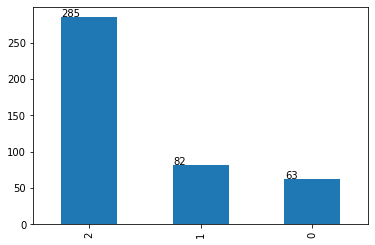

In [7]:
ax = df['Label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [8]:
df = df.reset_index(drop = True)
df.head()

,tweet,Label,cashtags,conversation_id,created_at,date,day,favorites,geo,has_media,hashtags,hour,id,img_urls,is_replied,is_reply_to,likes,link,links,mentions,name,near,nlikes,nreplies,nretweets,parent_tweet_id,place,quote_url,replies,reply_to,reply_to_users,retweet,retweet_date,retweet_id,retweets,screen_name,search,source,text_html,timestamp_epochs,timezone,trans_dest,trans_src,translate,tweet_id,user_id,user_id_str,user_rt,user_rt_id,username,video_url,lang,Tweet text processed
0,Worth your time- an # AirPollution status repo...,1,[],1.240000e+18,1.583591e+12,2020-03-07 14:28:56,6.0,NaN,NaN,NaN,"['#airpollution', '#india', '#coronavirus', '#...",14.0,1.240000e+18,NaN,NaN,NaN,NaN,https://twitter.com/CareForAirIndia/status/123...,NaN,NaN,Care for Air,NaN,3.0,0.0,3.0,NaN,NaN,NaN,NaN,"[{'user_id': '3872489297', 'username': 'CareFo...",NaN,False,NaN,NaN,NaN,NaN,#airpollution,NaN,NaN,NaN,UTC,NaN,NaN,NaN,NaN,3.872489e+09,3.872489e+09,NaN,NaN,CareForAirIndia,NaN,en,Worth your time- an #AirPollution status repor...
1,@ PMOIndia Sir Delhi is facing a lot of smog a...,2,NaN,NaN,NaN,2017-11-12 11:53,NaN,0.0,NaN,NaN,NaN,NaN,9.300000e+17,NaN,NaN,NaN,NaN,https://twitter.com/Rishabh_shetty8/status/929...,NaN,@,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rishabh_shetty8,NaN,en,@PMOIndia Sir Delhi is facing a lot of smog as...
2,India's own 'smog tower' may help combat air p...,2,NaN,NaN,NaN,2018-11-05 13:32,NaN,1.0,NaN,NaN,NaN,NaN,1.060000e+18,NaN,NaN,NaN,NaN,https://twitter.com/vishalfast007/status/10593...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vishalfast007,NaN,en,India's own 'smog tower' may help combat air p...
3,Delhi gets first smog tower to combat air poll...,2,NaN,NaN,NaN,2020-01-06 18:52:26,NaN,NaN,NaN,False,[],NaN,NaN,[],False,False,1.0,/irajeevuwho/status/1214258438168928256,['https://www.hindustantimes.com/cities/delhi-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,[],NaN,NaN,NaN,0.0,irajeevuwho,NaN,NaN,"<p class=""TweetTextSize js-tweet-text tweet-te...",1.578337e+09,NaN,NaN,NaN,NaN,1.210000e+18,1.010000e+18,NaN,NaN,NaN,Democrazy,NaN,en,Delhi gets first smog tower to combat air poll...
4,Finally some positive news in connection with ...,2,NaN,NaN,NaN,2019-11-17 10:42,NaN,6.0,NaN,NaN,#,NaN,1.200000e+18,NaN,NaN,NaN,NaN,https://twitter.com/SirSchweini/status/1195932...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SirSchweini,NaN,en,Finally some positive news in connection with ...


In [9]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU 
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

toc = Tokenizer()
toc.fit_on_texts(df['Tweet text processed'])

max_len = max(len(s.split()) for s in df['Tweet text processed'])

vocab_size = len(toc.word_index) + 1

In [10]:
from itertools import product
from sklearn.metrics import balanced_accuracy_score

def create_model(embedding_dim, neurons):
	# create model
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(32, return_sequences=True)))
  model.add((Bidirectional(LSTM(neurons))))
  #model.add(Dense(64, activation='relu'))
  #model.add(Dense(3, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
def GridSearchCV(X, y, train_val_index, y_train_val, param_grid):
  hyperpara_dict = {}
  # kfInner = StratifiedKFold(5, shuffle=True, random_state=0) # latest working
  # train_ind, val_ind = next(kfInner.split(train_val_index, y_train_val.idxmax(axis=1).values)) # latest working
  # train_df_ind = train_val_index[train_ind] # latest working
  # val_df_ind = train_val_index[val_ind] # latest working
  train_df_ind, val_df_ind = train_test_split(train_val_index, random_state=0, test_size=0.2)
  
  X_train, y_train = X.iloc[train_df_ind], y.iloc[train_df_ind]
  X_val, y_val = X.iloc[val_df_ind], y.iloc[val_df_ind]

  train_tocs = toc.texts_to_sequences(X_train)
  val_tocs = toc.texts_to_sequences(X_val)
  X_train_pad = pad_sequences(train_tocs, maxlen=max_len, padding='post')
  X_val_pad = pad_sequences(val_tocs, maxlen=max_len, padding='post')
  
  for embedding_dim, neurons, batch_size, epochs in product(*param_grid.values()):
    print('searching', (embedding_dim, neurons, batch_size, epochs))
    model = create_model(embedding_dim, neurons)
    model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    res = model.predict(X_val_pad)
    score = pd.DataFrame(res).max(axis =1)
    y_pred = pd.DataFrame(res, columns=[-1,0,1]).idxmax(axis=1)
    accuracy = f1_score(y_val.idxmax(axis=1), y_pred,average='macro')
    hyperpara_dict.update({(embedding_dim, neurons, batch_size, epochs) : accuracy})
  return max(hyperpara_dict, key=lambda x: hyperpara_dict[x]) # will return set of hyp having max accuracy


In [ ]:
# Main code
from sklearn.model_selection import train_test_split
X = df['Tweet text processed']
y = pd.get_dummies(df['Label'])
param_grid = {'embedding_dim':[32,64,128], 
               'neurons':[8,16,32,64], 
               'batch_size':[8,16,32], 
               'epochs' : [20, 30,50, 100]}
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
# kf = StratifiedKFold() # latest working
kf = KFold(5, shuffle=True, random_state=0)
test_inds = []
test_preds = []
test_score = []
test = []
for train_val_index, test_index in kf.split(X, y.idxmax(axis=1)):
  X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
  y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
  train_val_tocs = toc.texts_to_sequences(X_train_val)
  test_tocs = toc.texts_to_sequences(X_test)
  X_train_val_pad = pad_sequences(train_val_tocs, maxlen=max_len, padding='post')
  X_test_pad = pad_sequences(test_tocs, maxlen=max_len, padding='post')

  # Start Hyperpara tuning
  embedding_dim, neurons, batch_size, epochs = GridSearchCV(X, y, train_val_index, y_train_val, param_grid)
  print('best hyper', embedding_dim, neurons, batch_size, epochs)
  model = create_model(embedding_dim, neurons)
  model.fit(X_train_val_pad, y_train_val, batch_size=batch_size, epochs=epochs, verbose=0)
  res = model.predict(X_test_pad)
  score = pd.DataFrame(res).max(axis =1)
  y_pred = pd.DataFrame(res, columns=[-1,0,1]).idxmax(axis=1)
  accuracy = f1_score(y_test.idxmax(axis=1), y_pred,average='macro')
  print(accuracy)
  test_inds.extend(test_index)
  test_preds.extend(y_pred)
  test_score.extend(score)
  test.extend(y_test.idxmax(axis=1))

searching (32, 8, 8, 20)
searching (32, 8, 8, 30)
searching (32, 8, 8, 50)


In [ ]:
pd.to_pickle(test, 'test_ST')
pd.to_pickle(test_preds, 'test_preds_ST')

In [14]:
print(classification_report(test, np.array(test_preds)+1))
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
# from sklearn.model_selection import train_test_split
# print(test_preds)
# sns.heatmap((confusion_matrix(test,test_preds)),annot=True,annot_kws={"size": 40},cbar=False,fmt='g',
#             xticklabels=[-1,0,1], yticklabels=[-1,0,1])

# plt.xlabel('predicted')
# plt.ylabel('ground truth')
# plt.show()

              precision    recall  f1-score   support

           0       0.82      0.57      0.67        63
           1       0.56      0.63      0.59        82
           2       0.85      0.87      0.86       285

    accuracy                           0.78       430
   macro avg       0.74      0.69      0.71       430
weighted avg       0.79      0.78      0.78       430

